# Balance dataset: selection of trials

Marcos Duarte

Let's see how to select data from the Balance dataset, a public data set of quantitative and qualitative evaluations. See the companiom data set website [http://demotu.org/datasets/balance/](http://demotu.org/datasets/balance/) for more information.

We will use the power of python and its libraries to handle the data, particularly the [pandas](http://pandas.pydata.org/) library for handling labeled data, [Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) for plotting, and [Jupyter Notebook](http://jupyter.org/) as the web application for running all the code and the GUI widgets.

First, let's import the necessary Python libraries and configure the environment:

In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 2)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.4,
                rc={'font.size': 14, 'lines.linewidth': 2, 'lines.markersize': 10, 'axes.titlesize': 'x-large'})
sns.set_style("whitegrid")
import glob
import sys, os
sys.path.insert(1, r'./../functions')

# IPython widgets:
from IPython.display import display
import ipywidgets
from ipywidgets import FloatProgress, interactive

import qgrid  # pip install git+https://github.com/quantopian/qgrid
#qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to /nbextensions folder
qgrid.set_defaults(remote_js=True, precision=2)  # Set default options by calling "set_defaults" (optional)

## Load the metadata about the Balance dataset

The metadata of the Balance dataset are stored in ASCII files. See [http://demotu.org/datasets/balance/](http://demotu.org/datasets/balance/) for more information

In [2]:
# read file with all metadata and COP variables from the GitHub repo:
fname = 'https://raw.githubusercontent.com/demotu/datasets/master/Balance/BDSinfoCOP.txt'
path = r'./../../../X/BDB/'
fname = os.path.join(path, 'BDSinfoCOP.txt')
BDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=0, engine='c', encoding='utf-8')
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(BDSinfo.Subject)), BDSinfo.shape[0], BDSinfo.shape[1]))

Information of 163 subjects loaded (1930 rows, 67 columns).


Here are the first 10 columns of the data:

In [3]:
BDSinfo.iloc[:15, :10]
# or use the nice qgrid library:
#qgrid.show_grid(BDSinfo.iloc[:, :10])

,Subject,Trial,Vision,Surface,Age,AgeGroup,Gender,Height,Weight,BMI
0,1,BDS00001,Open,Firm,33.00,Young,F,157.5,54.2,21.85
1,1,BDS00002,Open,Firm,33.00,Young,F,157.5,54.2,21.85
2,1,BDS00003,Open,Firm,33.00,Young,F,157.5,54.2,21.85
3,1,BDS00004,Closed,Firm,33.00,Young,F,157.5,54.2,21.85
4,1,BDS00005,Closed,Firm,33.00,Young,F,157.5,54.2,21.85
5,1,BDS00006,Closed,Firm,33.00,Young,F,157.5,54.2,21.85
6,1,BDS00007,Open,Foam,33.00,Young,F,157.5,54.2,21.85
7,1,BDS00008,Open,Foam,33.00,Young,F,157.5,54.2,21.85
8,1,BDS00009,Open,Foam,33.00,Young,F,157.5,54.2,21.85
9,1,BDS00010,Closed,Foam,33.00,Young,F,157.5,54.2,21.85


## Data selection

Here are examples of how to select part of the data using pandas (see http://pandas.pydata.org/pandas-docs/stable/indexing.html):

In [4]:
# Select data from a single subject:
data = BDSinfo[BDSinfo.Subject==100]
print('There are %d trials for subject 100' %data.shape[0])
# Select data from a single condition:
data = BDSinfo[BDSinfo.Vision=='Open']
print('There are %d trials for the "Open" visual condition.' %data.shape[0])
# Select data based on multiple criteria:
criteria = (BDSinfo.AgeGroup=='Young') & (BDSinfo.Gender=='F')
data = BDSinfo[criteria]
print('There are %d trials satisfying the criteria AgeGroup = "Young" and Gender = "F".' %data.shape[0])

There are 12 trials for subject 100
There are 969 trials for the "Open" visual condition.
There are 672 trials satisfying the criteria AgeGroup = "Young" and Gender = "F".


We can calculate summary statistics for the selected data, for example:

In [5]:
print('Mean and standard-deviation values of the COParea and COPvelo variables for the young adults without disability:')
data = BDSinfo[(BDSinfo.AgeGroup=='Young') & (BDSinfo.Disability=='No')]
data.groupby(['Vision', 'Surface'])['COParea', 'COPvelo'].agg([np.mean, np.std])

Mean and standard-deviation values of the COParea and COPvelo variables for the young adults without disability:


COParea       COPvelo      
                  mean   std    mean   std
Vision Surface                            
Closed Firm       2.92  2.94    0.96  0.39
       Foam      14.91  6.47    3.11  1.04
Open   Firm       2.57  2.89    0.87  0.31
       Foam      12.59  6.07    2.34  0.68

And we can also plot the data.  
For example, consider the case for plotting the data of a certain subject versus the other subjects. Let's create a function for that:

In [6]:
def bdb_plot_barplot(data, sel, var='COParea', ylabel='Area ( cm$^2$)',
                     estimator=np.median, ci=95, ax=None, legend=None, sel_lege=True):
    '''
    Auxiliary plotting function to plot summary statistics of the Balance data set project.
    '''
    
    palette = {'Open': [.8, .8, .9], 'Closed': [.4, .4, .9]}
    axi = sns.barplot(x="Surface", y=var, hue="Vision", order=['Firm', 'Foam'], data=data, ci=ci,
                       hue_order=['Open', 'Closed'], estimator=estimator, palette=palette, ax=ax)
    if ylabel:
        ax.set_ylabel(ylabel)
    if legend:
        axi.legend(title='Eyes', loc='best')
    else:
        ax.legend('')
    # get the x,y values of the confidence intervals:
    xyci = []
    for ch in axi.get_children():
        if isinstance(ch, matplotlib.lines.Line2D):
            xyci.append(ch.get_data())
    if sel is not None:
        median = sel.groupby(['Vision', 'Surface'])['COParea', 'COPvelo'].agg(estimator)
        axi.plot(xyci[0][0][0], median[var]['Open']['Firm'], marker='o', color='r', markersize=10, label='Subject')
        axi.plot(xyci[2][0][0], median[var]['Closed']['Firm'], marker='o', color='r', markersize=10)
        axi.plot(xyci[1][0][0], median[var]['Open']['Foam'], marker='o', color='r', markersize=10)
        axi.plot(xyci[3][0][0], median[var]['Closed']['Foam'], marker='o', color='r', markersize=10)  
        x = axi.get_xlim()[0] + .05*(axi.get_xlim()[1]-axi.get_xlim()[0])
        y = axi.get_ylim()[0] + .9*(axi.get_ylim()[1]-axi.get_ylim()[0])
        x2 = axi.get_xlim()[0] + .1*(axi.get_xlim()[1]-axi.get_xlim()[0])
        y2 = axi.get_ylim()[0] + .88*(axi.get_ylim()[1]-axi.get_ylim()[0])
        if sel_lege:
            axi.plot(x, y, marker='o', color='r', markersize=10)
            axi.text(x2, y2, 'Subject', fontsize=14)
        
    return ax, xyci

Example of data selection and the plot:

In [7]:
# Select data from young adults without disability:
sel = BDSinfo[(BDSinfo.AgeGroup=='Young') & (BDSinfo.Disability=='No')]
# Select data of subject 1:
sel2 = BDSinfo[BDSinfo.Subject==1]

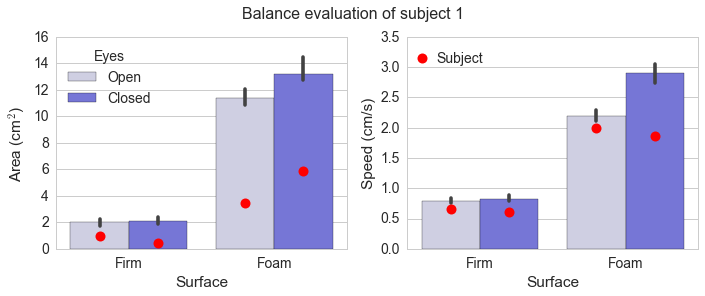

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
axa, xycia = bdb_plot_barplot(data=sel, sel=sel2, var='COParea', ylabel='Area (cm$^2$)', ax=ax[0],
                             legend=True, sel_lege=False)
axs, xycis = bdb_plot_barplot(data=sel, sel=sel2, var='COPvelo', ylabel='Speed (cm/s)', ax=ax[1])
plt.tight_layout()
plt.suptitle('Balance evaluation of subject 1', fontsize=16, y=1.03)
plt.show()

## Jupyter widget for data selection

With [Jupyter widgets](https://github.com/ipython/ipywidgets) we can create widgects for data selection.  
The Jupyter widgets will not appear on the static version of this notebook (if you seeing this notebook from GitHub), you will have to run this notebook for actually seeing the widgets.

In [9]:
subjects = np.hstack(('All subjects', np.sort(pd.unique(BDSinfo.Subject))))
ages = np.hstack(('All ages', pd.unique(BDSinfo.AgeGroup)))
genders = np.hstack(('All genders', pd.unique(BDSinfo.Gender)))
disability = np.hstack(('All conditions', pd.unique(BDSinfo.Disability)))
illness = np.hstack(('All conditions', pd.unique(BDSinfo.Illness)))
visions = np.hstack(('All visions', pd.unique(BDSinfo.Vision)))
surfaces = np.hstack(('All surfaces', pd.unique(BDSinfo.Surface)))

wsubjects = ipywidgets.Dropdown(options=list(subjects), value='All subjects', description='Subjects', width=300, margin=2)
wages = ipywidgets.Dropdown(options=list(ages), value='All ages', description='Ages', width=300, margin=2)
wgenders = ipywidgets.Dropdown(options=list(genders), value='All genders', description='Genders', width=300, margin=2)
wdisabilitys = ipywidgets.Dropdown(options=list(disability), value='All conditions', description='Disabilities',
                                   width=300, margin=2)
willness = ipywidgets.Dropdown(options=list(illness), value='All conditions', description='Illness', width=300, margin=2)
wvisions = ipywidgets.Dropdown(options=list(visions), value='All visions', description='Visions', width=300, margin=2)
wsurfaces = ipywidgets.Dropdown(options=list(surfaces), value='All surfaces', description='Surfaces', width=300, margin=2)
t1 = ipywidgets.HTML(value="<b>Trials selection for the database:</b>")
trial_sel = ipywidgets.VBox(children=[t1, wsubjects, wgenders, wages, wdisabilitys, willness, wvisions, wsurfaces])

wsubjects2 = ipywidgets.Dropdown(options=list(subjects), value='All subjects', description='Subjects', width=300, margin=2)
wages2 = ipywidgets.Dropdown(options=list(ages), value='All ages', description='Ages', width=300, margin=2)
wgenders2 = ipywidgets.Dropdown(options=list(genders), value='All genders', description='Genders', width=300, margin=2)
wdisabilitys2 = ipywidgets.Dropdown(options=list(disability), value='All conditions', description='Disabilities', 
                                    width=300, margin=2)
willness2 = ipywidgets.Dropdown(options=list(illness), value='All conditions', description='Illness', width=300, margin=2)
wvisions2 = ipywidgets.Dropdown(options=list(visions), value='All visions', description='Visions', width=300, margin=2)
wsurfaces2 = ipywidgets.Dropdown(options=list(surfaces), value='All surfaces', description='Surfaces', width=300, margin=2)
t2 = ipywidgets.HTML(value="<b>Trials selection for the comparison:</b>")
trial_sel2 = ipywidgets.VBox(children=[t2, wsubjects2, wgenders2, wages2, wdisabilitys2, willness2, wvisions2, wsurfaces2])

container = ipywidgets.HBox(children=[trial_sel, trial_sel2])
container.border_color = '#F2F2F2'
container.border_width = 2
container.background_color = '#F2F2F2'
display(container)

## Summary results for selected data

In [10]:
subject_sel = list(subjects) if wsubjects.value == 'All subjects' else wsubjects.value
subject_sel = BDSinfo['Subject'].map(lambda x: str(x) in subject_sel)
gender_sel = ['F', 'M'] if wgenders.value == 'All genders' else wgenders.value
gender_sel = BDSinfo['Gender'].map(lambda x: x in gender_sel)
if wages.value == 'All ages':
    age_sel = BDSinfo['Age'].map(lambda x: x > 0)
elif wages.value == 'Young':
    age_sel = BDSinfo['Age'].map(lambda x: x < 60)
else:
    age_sel = BDSinfo['Age'].map(lambda x: x >= 60)
disability_sel = ['Yes', 'No'] if wdisabilitys.value == 'All conditions' else wdisabilitys.value
disability_sel = BDSinfo['Disability'].map(lambda x: x in disability_sel)
illness_sel = ['Yes', 'No'] if willness.value == 'All conditions' else willness.value
illness_sel = BDSinfo['Illness'].map(lambda x: x in illness_sel)
vision_sel = ['Open', 'Closed'] if wvisions.value == 'All visions' else wvisions.value
vision_sel = BDSinfo['Vision'].map(lambda x: x in vision_sel)
surface_sel = ['Firm', 'Foam'] if wsurfaces.value == 'All surfaces' else wsurfaces.value
surface_sel = BDSinfo['Surface'].map(lambda x: x in surface_sel)
sel = BDSinfo[subject_sel & gender_sel & age_sel & illness_sel & disability_sel & vision_sel & surface_sel]
print('%s subjects selected.' %len(pd.unique(sel.Subject)))
sel.groupby(['Vision', 'Surface'])['COParea', 'COPvelo'].agg(np.median)

subject_sel2 = list(subjects) if wsubjects2.value == 'All subjects' else wsubjects2.value
subject_sel2 = BDSinfo['Subject'].map(lambda x: str(x) in subject_sel2)
gender_sel2 = ['F', 'M'] if wgenders2.value == 'All genders' else wgenders2.value
gender_sel2 = BDSinfo['Gender'].map(lambda x: x in gender_sel2)
if wages2.value == 'All ages':
    age_sel2 = BDSinfo['Age'].map(lambda x: x > 0)
elif wages2.value == 'Young':
    age_sel2 = BDSinfo['Age'].map(lambda x: x < 60)
else:
    age_sel2 = BDSinfo['Age'].map(lambda x: x >= 60)
disability_sel2 = ['Yes', 'No'] if wdisabilitys2.value == 'All conditions' else wdisabilitys2.value
disability_sel2 = BDSinfo['Disability'].map(lambda x: x in disability_sel2)
illness_sel2 = ['Yes', 'No'] if willness2.value == 'All conditions' else willness2.value
illness_sel2 = BDSinfo['Illness'].map(lambda x: x in illness_sel2)
vision_sel2 = ['Open', 'Closed'] if wvisions2.value == 'All visions' else wvisions2.value
vision_sel2 = BDSinfo['Vision'].map(lambda x: x in vision_sel2)
surface_sel2 = ['Firm', 'Foam'] if wsurfaces2.value == 'All surfaces' else wsurfaces2.value
surface_sel2 = BDSinfo['Surface'].map(lambda x: x in surface_sel2)
sel2 = BDSinfo[subject_sel2 & gender_sel2 & age_sel2 & illness_sel2 & disability_sel2 & vision_sel2 & surface_sel2]
print('%s subjects selected.' %len(pd.unique(sel2.Subject)))
sel2.groupby(['Vision', 'Surface'])['COParea', 'COPvelo'].agg(np.median)

83 subjects selected.
64 subjects selected.


COParea  COPvelo
Vision Surface                  
Closed Firm        2.19     1.08
       Foam       22.91     4.12
Open   Firm        2.17     1.00
       Foam       18.15     3.50

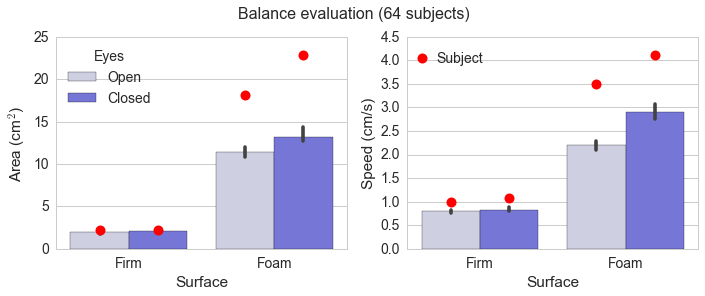

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
axa, xycia = bdb_plot_barplot(data=sel, sel=sel2, var='COParea', ylabel='Area (cm$^2$)', ax=ax[0],
                             legend=True, sel_lege=False)
axs, xycis = bdb_plot_barplot(data=sel, sel=sel2, var='COPvelo', ylabel='Speed (cm/s)', ax=ax[1])
plt.tight_layout()
subjects = pd.unique(sel2.Subject)
if sel is not None and len(pd.unique(sel.Subject)) == 1:
    title = 'Balance evaluation (subject: %s)' %sel['Subject'].iloc[0]
else:
    title = 'Balance evaluation (%d subjects)' %len(subjects)
plt.suptitle(title, fontsize=16, y=1.03)
plt.show()